In [63]:
from requests import get
import re

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [80]:
#read in the dataframe
csv = pd.read_csv('all_streaming.csv')
df = pd.DataFrame(csv)

#select the needed columns and rename them appropriately
df = df[['movie_or_serie', 'title','gender_type', 'release_year', 'duration_seconds', 'channel_streaming']]
df = df.rename(columns={'movie_or_serie':'type', 'gender_type':'genre'})
df = df.copy()

#rename the streaming services so they are more accessible
df['channel_streaming'] = df['channel_streaming'].replace(
    {'disney-movies-and-tv-shows': 'Disney+', 
     'amazon-prime-movies-and-tv-shows':'Prime', 
     'netflix-shows':'Netflix', 
     'hulu-movies-and-tv-shows':'Hulu'})

#select the primary genre for each item
df['primary_genre'] = df['genre'].str.split('>').str[0]

#filter out only the movies
movies = df[df['type'] == 'Movie'].copy()
pd.set_option('display.max_rows', 50)

#rename genres so they are more accessible
movies['primary_genre'] = movies['primary_genre'].replace(
    {'dramas': 'drama', 
     'documentaries':'documentary', 
     'actionadventure':'action', 
     'adventure':'action',
     'kids':'children',
     'comedies':'comedy',
     'arthouse':'arts',
    'st':'short'})

movies


,type,title,genre,release_year,duration_seconds,channel_streaming,primary_genre
0,Movie,Duck the Halls: A Mickey Mouse Christmas Special,animation>family,2016,23 min,Disney+,animation
1,Movie,Ernest Saves Christmas,comedy,1988,91 min,Disney+,comedy
2,Movie,Ice Age: A Mammoth Christmas,animation>comedy>family,2011,23 min,Disney+,animation
3,Movie,The Queen Family Singalong,musical,2021,41 min,Disney+,musical
5,Movie,Becoming Cousteau,biographical>documentary,2021,94 min,Disney+,biographical
...,...,...,...,...,...,...,...
22990,Movie,The Man in the Hat,comedy,2021,96 min,Prime,comedy
22992,Movie,River,drama>science>fiction>suspense,2021,93 min,Prime,drama
22993,Movie,Pride Of The Bowery,comedy,1940,60 min,Prime,comedy
22995,Movie,Outpost,action,2008,90 min,Prime,action


In [101]:
top_10_genres = movies['primary_genre'].value_counts().head(10)
top_10_genres


drama          3788
action         3043
comedy         2864
documentary    1766
horror          941
children        871
arts            551
animation       515
short           334
suspense        187
Name: primary_genre, dtype: int64

In [95]:
#select the top 10 genres and filter the movies dataset so only movies with these genres are included
top_10_genres = movies['primary_genre'].value_counts().head(10).index

top_genre_movies = movies[movies['primary_genre'].isin(top_10_genres)]
top_genre_movies

,type,title,genre,release_year,duration_seconds,channel_streaming,primary_genre
0,Movie,Duck the Halls: A Mickey Mouse Christmas Special,animation>family,2016,23 min,Disney+,animation
1,Movie,Ernest Saves Christmas,comedy,1988,91 min,Disney+,comedy
2,Movie,Ice Age: A Mammoth Christmas,animation>comedy>family,2011,23 min,Disney+,animation
9,Movie,A Muppets Christmas: Letters To Santa,comedy>family>musical,2008,45 min,Disney+,comedy
10,Movie,Adventure Thru the Walt Disney Archives,documentary,2020,59 min,Disney+,documentary
...,...,...,...,...,...,...,...
22990,Movie,The Man in the Hat,comedy,2021,96 min,Prime,comedy
22992,Movie,River,drama>science>fiction>suspense,2021,93 min,Prime,drama
22993,Movie,Pride Of The Bowery,comedy,1940,60 min,Prime,comedy
22995,Movie,Outpost,action,2008,90 min,Prime,action


In [96]:
#show genre counts by streaming services
genre_counts_per_streaming = top_genre_movies.groupby(['channel_streaming', 'primary_genre']).size().unstack(fill_value=0)
genre_counts_per_streaming

primary_genre,action,animation,arts,children,comedy,documentary,drama,horror,short,suspense
channel_streaming,,,,,,,,,,
Disney+,314,259,0,0,144,65,25,0,0,0
Hulu,309,0,0,12,257,249,241,144,0,0
Netflix,859,0,0,605,1210,829,1600,275,334,0
Prime,1561,256,551,254,1253,623,1922,522,0,187


In [97]:
#show genre proportions by streaming service 
total_movies_per_streaming = genre_counts_per_streaming.sum(axis=1)
genre_proportions_per_streaming = genre_counts_per_streaming.div(total_movies_per_streaming, axis=0)
genre_proportions_per_streaming

primary_genre,action,animation,arts,children,comedy,documentary,drama,horror,short,suspense
channel_streaming,,,,,,,,,,
Disney+,0.389095,0.320942,0.00000,0.000000,0.178439,0.080545,0.030979,0.000000,0.000000,0.000000
Hulu,0.254950,0.000000,0.00000,0.009901,0.212046,0.205446,0.198845,0.118812,0.000000,0.000000
Netflix,0.150385,0.000000,0.00000,0.105917,0.211835,0.145133,0.280112,0.048144,0.058473,0.000000
Prime,0.218965,0.035910,0.07729,0.035629,0.175761,0.087390,0.269603,0.073222,0.000000,0.026231


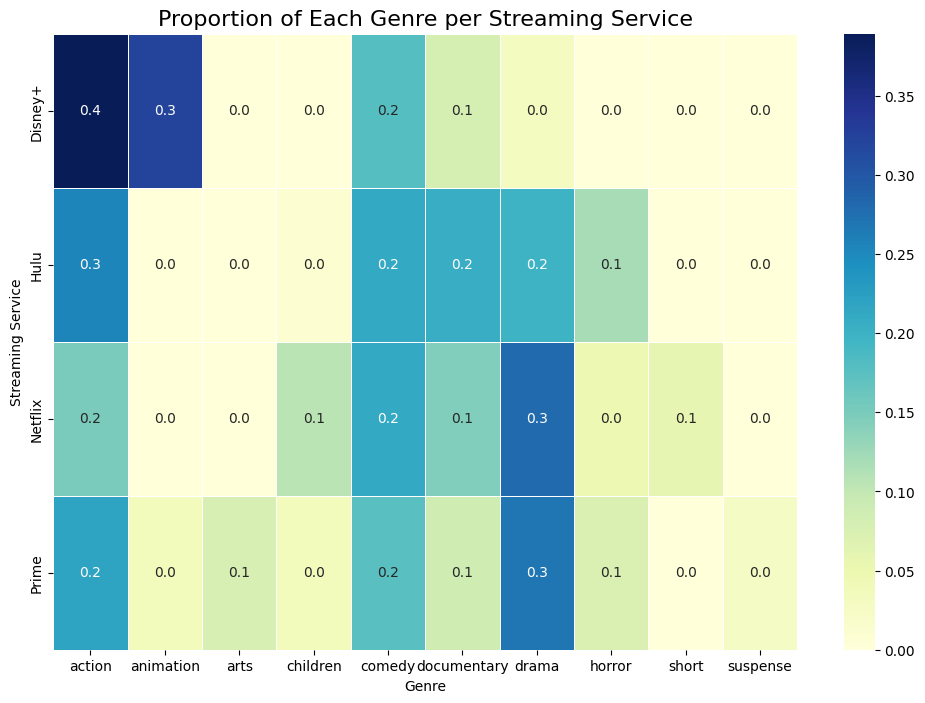

In [100]:
#plot the data on a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(genre_proportions_per_streaming, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=0.5)

# Add title and labels
plt.title("Proportion of Each Genre per Streaming Service", fontsize=16)
plt.xlabel("Genre")
plt.ylabel("Streaming Service")

plt.show()